<a href="https://colab.research.google.com/github/donktark/Donktark.Python/blob/master/AI_vs_Human_%ED%85%8D%EC%8A%A4%ED%8A%B8_%ED%8C%90%EB%B3%84_%ED%95%B4%EC%BB%A4%ED%86%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install transformers
# !pip install optuna
# !pip install datasets
# !pip install torch
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install konlpy
# !pip3 install mecab-python3

In [ ]:
#기본
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import warnings

#전처리
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, DistilBertTokenizer, DataCollatorWithPadding
import re
from konlpy.tag import Mecab, Okt

#모델
import torch
from datasets import Dataset
from transformers import BertForMultipleChoice, Trainer, TrainingArguments,  DistilBertForMultipleChoice, BertForSequenceClassification
from sklearn.metrics import average_precision_score, precision_score

# 데이터 불러오기, 분할

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(84)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/AI vs Human/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/AI vs Human/test.csv')
k_stopword = list(pd.read_table('/content/drive/MyDrive/Colab Notebooks/data/불용어 사전.txt', header=None)[0])

In [ ]:
# multiple choice 모델 로드

model_name = 'kykim/bert-kor-base'
# model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# def model_init(trial):
#   return DistilBertForMultipleChoice.from_pretrained(model_name)

# model = BertForMultipleChoice.from_pretrained(model_name)
# model.config.max_position_embeddings = 32


# classification 모델 로드

def cl_model_init(trial):
  return BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# model = DistilBertForMultipleChoice.from_pretrained(model_name, num_labels=4).to(device)
# model.config.max_position_embeddings = 32

In [ ]:
train_text = train_df.copy()
okt = Okt()

def preprocessing_text(x):
    text = re.sub(r'[^가-힣\s]', "", x) #공백 한글 빼고 모두 제거
    text = okt.morphs(text)
    text = [w for w in text if w not in k_stopword]
    return " ".join(text)

for i in range(1, 5):
    train_text[f'sentence{i}'] = train_df[f'sentence{i}'].apply(lambda x : preprocessing_text(x))

train_text, valid_text = train_test_split(train_text, test_size = 0.2)

(array([ 1.,  3.,  7.,  5.,  3.,  3., 12.,  4.,  0.,  2.]),
 array([35. , 39.8, 44.6, 49.4, 54.2, 59. , 63.8, 68.6, 73.4, 78.2, 83. ]),
 <BarContainer object of 10 artists>)

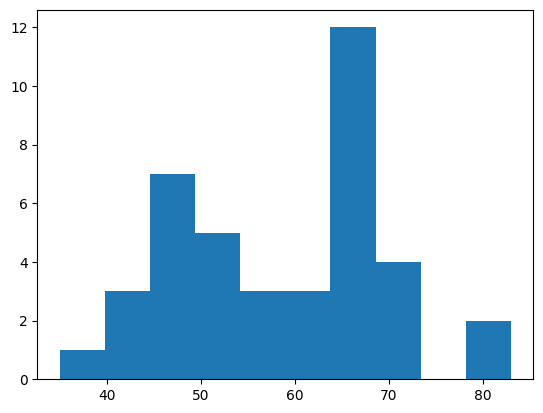

In [ ]:
sentence_len = []

for i, r in train_text.drop('label', axis=1).iterrows():
    max_len = max([len(r[f'sentence{j}'].split()) for j in range(1,5)])
    sentence_len.append(max_len)
plt.hist(sentence_len)

메모리 효율을 위해서 토크나이즈시 max_length를 조정.

In [ ]:
# choices = []
# for i in range(len(train_text)):
#     choice_list = [train_text[f'sentence{i}'].values.tolist() for i in range(1, 5)]
#     choices.append(choice_list)

# # 라벨 데이터
# labels = torch.tensor(train_text["label"].values - 1)

# # 각 문장을 토큰화 및 인코딩
# input_ids = []
# attention_masks = []
# for choice_list2 in choices:
#     choice_token = [tokenizer(sentence, padding="max_length", max_length=60, return_tensors="pt", truncation=True) for sentence in choice_list2]
#     input_ids.append([item['input_ids'] for item in choice_token])
#     attention_masks.append([item['attention_mask'] for item in choice_token])

# # 데이터셋 생성
# class make_dataset(torch.utils.data.Dataset):
#     def __init__(self, input_ids, attention_masks, labels):
#         self.input_ids = input_ids
#         self.attention_masks = attention_masks
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return {
#             "input_ids": self.input_ids[idx],
#             "attention_mask": self.attention_masks[idx],
#             "labels": self.labels[idx],
#         }
# train_ds = make_dataset(input_ids, attention_masks, labels)

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
binary_labels_tr = []
for index, row in train_text.iterrows():
    for i in range(1, 5):
        sentence = row[f"sentence{i}"]
        is_answer = 1 if row["label"] == i else 0
        binary_labels_tr.append({"text": sentence, "labels": is_answer})

binary_labels_val = []
for index, row in valid_text.iterrows():
    for i in range(1, 5):
        sentence = row[f"sentence{i}"]
        is_answer = 1 if row["label"] == i else 0
        binary_labels_val.append({"text": sentence, "labels": is_answer})

train_bin = pd.DataFrame(binary_labels_tr)
valid_bin = pd.DataFrame(binary_labels_val)

class make_dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=65):
        self.encodings = tokenizer(
            texts,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
            truncation=True,
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_ds_cl =  make_dataset(train_bin['text'].tolist(), train_bin['labels'], tokenizer, max_length=70)
valid_ds_cl =  make_dataset(valid_bin['text'].tolist(), valid_bin['labels'], tokenizer, max_length=70)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
train_ds_cl

In [ ]:
# train_set, valid_set = train_test_split(train_df, test_size = 0.3)
# train_ds = Dataset.from_pandas(train_set)
# valid_ds = Dataset.from_pandas(valid_set)

# 모델

# Classification

In [ ]:
#평가지표
def compute_metrix(p):
    predictions = p.predictions.argmax(axis=1)
    true_labels = p.label_ids
    precision = precision_score(true_labels, predictions)
    return {"precision": precision}


#하이퍼 파라미터 목록
def optuna_hp_space(trial):
    return {
        'learning_rate' : trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "per_device_train_batch_size" : trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "per_device_eval_batch_size" : trial.suggest_categorical("per_device_eval_batch_size", [4, 8, 16])
    }


#하이퍼 파라미터 입력
training_args = TrainingArguments(
    output_dir="./bert_model",
    num_train_epochs=10,
    evaluation_strategy="steps",
    save_total_limit=2,
    eval_steps=20,
    load_best_model_at_end=True,
)

#트레이너 설정
trainer = Trainer(
    # model = model,
    model_init = cl_model_init,
    args = training_args,
    train_dataset = train_ds_cl,
    eval_dataset = valid_ds_cl,
    compute_metrics = compute_metrix,
    data_collator = data_collator,
    # tokenizer = tokenizer
)

best_trial = trainer.hyperparameter_search(
    direction = "maximize",
    backend = 'optuna',
    hp_space = optuna_hp_space,
    n_trials = 10,
)

# trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-10-29 14:26:05,472] A new study created in memory with name: no-name-53553bf1-eaa5-458f-8d47-d63b206a9dea
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision
20,No log,0.606606,0.000000
40,No log,0.569874,0.000000
60,No log,0.563750,0.000000
80,No log,0.564960,0.000000
100,No log,0.562392,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Step,Training Loss,Validation Loss,Precision
20,No log,0.616118,0.000000
40,No log,0.574950,0.000000
60,No log,0.566993,0.000000
80,No log,0.585981,0.000000
100,No log,0.562559,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Step,Training Loss,Validation Loss,Precision
20,No log,0.979900,0.000000
40,No log,1.873155,0.000000
60,No log,1.869591,0.250000
80,No log,0.566378,0.000000
100,No log,0.903554,0.000000
120,No log,0.601710,0.000000
140,No log,0.605779,0.000000
160,No log,0.917055,0.000000
180,No log,0.709627,0.250000
200,No log,0.571607,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Step,Training Loss,Validation Loss,Precision
20,No log,0.484058,0.000000
40,No log,0.456788,0.857143
60,No log,0.238270,0.818182
80,No log,0.357648,0.900000
100,No log,0.434903,0.888889


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-29 14:27:22,477] Trial 3 finished with value: 0.8888888888888888 and parameters: {'learning_rate': 0.00015144558905940862, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8}. Best is trial 3 with value: 0.8888888888888888.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision
20,No log,1.170492,0.000000
40,No log,0.896160,0.250000
60,No log,0.577567,0.000000
80,No log,0.600976,0.000000
100,No log,0.567667,0.000000
120,No log,0.562601,0.000000
140,No log,0.642740,0.000000
160,No log,0.586479,0.000000
180,No log,0.563286,0.000000
200,No log,0.568896,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Step,Training Loss,Validation Loss,Precision
20,No log,0.565636,0.000000
40,No log,0.499646,1.000000
60,No log,0.345285,0.857143
80,No log,0.508644,0.500000
100,No log,0.272198,0.888889
120,No log,0.141296,0.909091
140,No log,0.508202,0.769231
160,No log,0.849736,0.833333
180,No log,0.473396,0.875000
200,No log,0.630197,0.714286


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-29 14:28:08,531] Trial 5 finished with value: 0.75 and parameters: {'learning_rate': 0.00011086046865577945, 'per_device_train_batch_size': 4, 'per_device_eval_batch_size': 8}. Best is trial 3 with value: 0.8888888888888888.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision
20,No log,1.107394,0.000000
40,No log,1.583924,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-29 14:28:15,747] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision
20,No log,0.570069,0.000000
40,No log,0.563847,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-29 14:28:25,606] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Precision
20,No log,1.511420,0.000000
40,No log,1.385679,0.250000
60,No log,0.674257,0.000000
80,No log,0.860710,0.250000
100,No log,0.590728,0.000000
120,No log,0.627009,0.000000
140,No log,0.566572,0.000000
160,No log,0.578692,0.000000
180,No log,0.569225,0.000000
200,No log,0.562336,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Step,Training Loss,Validation Loss,Precision
20,No log,1.464188,0.000000
40,No log,1.124112,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-29 14:28:49,216] Trial 9 pruned. 


In [ ]:
print(best_trial)
best_hp = best_trial.hyperparameters
best_model = cl_model_init(best_hp)

BestRun(run_id='3', objective=0.8888888888888888, hyperparameters={'learning_rate': 0.00015144558905940862, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8}, run_summary=None)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
binary_labels_ts = []
test_text = test_df.copy()

for i in range(1, 5):
    train_text[f'sentence{i}'] = test_df[f'sentence{i}'].apply(lambda x : preprocessing_text(x))

for index, row in test_text.iterrows():
    for i in range(1, 5):
        sentence = row[f"sentence{i}"]
        binary_labels_ts.append(sentence)

test_bin = pd.DataFrame(binary_labels_ts)
test_token = [tokenizer(sentence, padding='max_length', max_length = 70, truncation=True) for sentence in test_bin[0]]
test_ds = Dataset.from_pandas(pd.DataFrame(test_token))

In [ ]:
preds = Trainer(model = best_model).predict(test_ds)

In [ ]:
pred_logits = preds.predictions[:, 1]

# logits를 4개씩 그룹으로 분할
grouped_logits = [pred_logits[i:i+4] for i in range(0, len(pred_logits), 4)]

result = []

# 각 행에서 가장 큰 값 2개의 인덱스를 추출하고 결합하여 저장
for row in grouped_logits:
    top_indices = sorted(np.argsort(row)[-2:]+1)  # 가장 큰 값 2개의 인덱스
    combined_index = str(f"{top_indices[0]}{top_indices[1]}")
    result.append(combined_index)

print(result)

['12', '14', '13', '14', '23', '34', '23', '13', '34', '23', '24', '24', '23', '34', '34', '23', '14', '23', '23', '13', '23', '12', '12', '23', '14', '34', '13', '24', '13', '13', '23', '14', '12', '13', '13', '13', '23', '24', '13', '14', '13', '23', '12', '23', '24', '12', '13', '34', '14', '13', '14', '23', '12', '13', '23', '23', '24', '34', '23', '23', '24', '13', '14', '12', '13', '12', '13', '34', '12', '13', '34', '14', '13', '12', '34', '14', '34', '14', '14', '34', '13', '13', '13', '23', '34', '13', '12', '13', '14', '24', '14', '23', '34', '12', '14', '14', '34', '13', '23', '34', '34', '12', '23', '24', '23', '23', '24', '12', '12', '23', '12', '24', '14', '34', '13', '12', '12', '23', '12', '12', '14', '34', '13', '23', '13', '12', '24', '24', '24', '14', '34', '12', '14', '34', '13', '13', '23', '34', '34', '13', '34', '24', '12', '24', '14', '23', '24', '34', '13', '14', '23', '14', '12', '12', '34', '13', '34', '23', '12', '23', '24', '14', '14', '23', '34', '24', '12

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/AI vs Human/sample_submission.csv')
submit['label'] = result
submit.head()
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/data/AI vs Human/submit3.csv', index=False)

# Multiple Choice

In [ ]:
# # #평가지표
# # def compute_metrix(p):
# #     top_k = p.predictions.argsort()[:, -2:]
# #     true_labels = p.label_ids
# #     map_at_2 = [average_precision_score([label in top for label in true_labels], [1, 1]) for top in top_k]
# #     return {"mAP@2": sum(map_at_2) / len(map_at_2)}


# # #하이퍼 파라미터 목록
# # def optuna_hp_space(trial):
# #     return {
# #         'learning_rate' : trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
# #         "per_device_train_batch_size" : trial.suggest_categorical("per_device_train_batch_size", [4, 8]),
# #         "per_device_eval_batch_size" : trial.suggest_categorical("per_device_eval_batch_size", [4, 8])
# #     }


# #하이퍼 파라미터 입력
# training_args = TrainingArguments(
#     output_dir="./bert_model",
#     # learning_rate=learning_rate,
#     # per_device_train_batch_size=8,
#     # num_train_epochs=3,
#     # evaluation_strategy="steps",
#     save_total_limit=2,
#     # eval_steps=10,
#     # load_best_model_at_end=True,
# )

# #트레이너 설정
# trainer = Trainer(
#     model = model,
#     # model_init = model_init,
#     args = training_args,
#     train_dataset = train_ds,
#     # eval_dataset = valid_ds,
#     # compute_metrics = compute_metrix,
#     data_collator = data_collator,
#     # tokenizer = tokenizer
# )

# # best_trial = trainer.hyperparameter_search(
# #     direction = "maximize",
# #     backend = 'optuna',
# #     hp_space = optuna_hp_space,
# #     n_trials = 10,
# # )

# trainer.train()


In [ ]:
# #간단모델

# train_choices = []
# train_labels = []

# for idx, row in train_df.iterrows():
#     choice_list = [row[f'sentence{i}'] for i in range(1, 5)]
#     train_choices.append(choice_list)
#     train_labels.append(row['label'] - 1)

# model.train()
# input_ids = []
# attention_mask = []

# for choice_list in train_choices:
#     inputs = tokenizer(choice_list, return_tensors="pt", padding='max_length', max_length = 55, truncation=True)
#     input_ids.append(inputs['input_ids'])
#     attention_mask.append(inputs['attention_mask'])

# input_ids = torch.stack(input_ids)
# attention_mask = torch.stack(attention_mask)
# labels = torch.tensor(train_labels)

# outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
# loss = outputs.loss
# loss.backward()

# # 테스트 데이터 준비
# test_choices = []
# for idx, row in test_df.iterrows():
#     choice_list = [row[f'sentence{i}'] for i in range(1, 5)]
#     test_choices.append(choice_list)

# # 모델 예측
# model.eval()
# results = []

# for choice_list in test_choices:
#     inputs = tokenizer(choice_list, return_tensors="pt", padding=True, truncation=True)
#     input_ids = inputs['input_ids']
#     attention_mask = inputs['attention_mask']
#     logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
#     predicted_label = torch.argmax(logits).item()
#     results.append(predicted_label + 1)  # 정답은 1부터 4로 인덱싱되어 있음

# # 결과 출력
# test_df['predicted_label'] = results
# test_df.to_csv('test_predictions.csv', index=False)